# CADC Astroquery
Astroquery is package that provides a set of tools to query astronomical databases. In this tutorial, we will focus on the CADC package of astroquery, which queries data provided by the Canadian Astronomical Data Centre (http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca ). This tutorial will go through an example of runing a query to displaying an image. We will gather images from PansSTARRS DR1g, HST, and CFHT, do a cutout of the area we want, and display the three images.


# Tutorial
This tutorial will go through some of the basic functionalities of the CADC astroquery package. The CADC module can be installed using the command:

```
$ pip install --pre astroquery
```

(The `--pre` tag installs the pre-release version which we need because the CADC package is not in the latest release.) Alternatively, you can clone and install from the source:

```
$ # If you have a github account:
$ git clone git@github.com:astropy/astroquery.git
$ # If you do not:
$ git clone https://github.com/astropy/astroquery.git
$ cd astroquery
$ python setup.py install
```

More information about astroquery can be found at the github repository https://github.com/astropy/astroquery.

Now, onto the tutorial. The first step is to import the CADC module from astroquery.

In [140]:
from astroquery.cadc import Cadc
cadc = Cadc()


## Querying
Now we can query the CADC database and retreive the data we want. Let's take a look at MegaPipe data in the D2 field, and compare it to HST images in the same area. The MegaPipe collection is MegaPrime data collected by the CFHT MegaCama and stacked at the CADC (http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/cfht/). The D2 field is in the region `10:00:28 02:12:30` https://www.cfht.hawaii.edu/Science/CFHLS/cfhtlsdeepwidefields.html) so let's query around that area for both CFHT and HST data. We also want to restrict results to calibrated images of good quality.

For MegaPipe images, we want energy bands in the R ($\lambda_{eff} = 658 nm$) or I ($\lambda_{eff} = 806 nm$) range (https://en.wikipedia.org/wiki/Photometric_system).

For HST images, energy bands use the WFC system, and TBH I'm not sure which filter we would like (http://www.stsci.edu/hst/wfc3/ins_performance/ground/components/filters).


First we grab the coordinates of the D2 field:


In [141]:
from astropy.coordinates import SkyCoord

c = SkyCoord('10h00m28s', '02d12m30s', frame='icrs', unit='deg')
print(c)

<SkyCoord (ICRS): (ra, dec) in deg
    (150.11666667, 2.20833333)>


Now using the coordinates of the D2 field, we build our query:

In [143]:
query_vars = { 'ra': c.ra.degree, 'dec': c.dec.degree, 'radius': 0.016}
query = '''SELECT *
FROM caom2.Plane AS Plane 
JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID 
WHERE ( Observation.collection IN ('CFHTMEGAPIPE','HST')
AND ( Observation.target_name LIKE 'D2%' OR Observation.target_name LIKE 'COSMOS%' )
AND ( Plane.calibrationLevel = 3 )
AND ( Plane.dataProductType = 'image')
AND ( Plane.energy_bandpassName LIKE 'r.%' OR Plane.energy_bandpassName LIKE 'i.%' OR Plane.energy_bandpassName LIKE 'F%')
AND ( Contains( CIRCLE('ICRS',
{ra},
{dec},
{radius}),
Plane.position_bounds ) = 1 )
AND ( Plane.quality_flag IS NULL OR Plane.quality_flag != 'junk' ))'''.format(**query_vars)

job = cadc.run_query(query, 'sync')
results = job.get_results()

In [144]:
columns_subset = [
 'productID',
 'collection',
 'observationID',
 'energy_bandpassName',
 'calibrationLevel',
    'position_resolution',
'position_sampleSize',
'position_dimension_naxis1',
'position_dimension_naxis2',
 'algorithm_name',
 'type',
 'intent',
 'target_name',
 'telescope_name',
 'instrument_name',
 'position_bounds',
 'dataProductType',
]
results.sort('productID')

results[columns_subset].show_in_notebook()

idx,productID,collection,observationID,energy_bandpassName,calibrationLevel,position_resolution,position_sampleSize,position_dimension_naxis1,position_dimension_naxis2,algorithm_name,type,intent,target_name,telescope_name,instrument_name,position_bounds,dataProductType
,,,,,,arcsec,arcsec,,,,,,,,,deg,
0,D2.I,CFHTMEGAPIPE,D2,i.MP9701,3,0.8300000000000001,0.18594036810000003,20341,21481,MEGAPIPE,OBJECT,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
1,D2.IQ.I,CFHTMEGAPIPE,D2.IQ,i.MP9701,3,0.64,0.18594036810000003,20341,21481,MEGAPIPE,OBJECT,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
2,D2.IQ.R,CFHTMEGAPIPE,D2.IQ,r.MP9601,3,0.64,0.18594036810000003,20341,21481,MEGAPIPE,OBJECT,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
3,D2.R,CFHTMEGAPIPE,D2,r.MP9601,3,0.84,0.18594036810000003,20341,21481,MEGAPIPE,OBJECT,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image
4,G025.150.118+02.207.I3,CFHTMEGAPIPE,G025.150.118+02.207,i.MP9703,3,1.02,0.185589860484456,24722,20483,MEGAPIPE,OBJECT,science,D2,CFHT 3.6m,MegaPrime,[149.48339110622874 1.6817153538897978 149.48293764564525 2.737574824181491 150.75877389715515 2.737574824181462 150.75832043657107 1.6817153538897691],image
5,G025.150.118+02.207.R3,CFHTMEGAPIPE,G025.150.118+02.207,r.MP9602,3,0.68,0.185589860484456,24722,20483,MEGAPIPE,OBJECT,science,D2,CFHT 3.6m,MegaPrime,[149.48339110622874 1.6817153538897978 149.48293764564525 2.737574824181491 150.75877389715515 2.737574824181462 150.75832043657107 1.6817153538897691],image
6,MegaPipe.300.184.I.MP9703,CFHTMEGAPIPE,MegaPipe.300.184,i.MP9703,3,--,0.185768447408928,10000,10000,MEGAPIPE,OBJECT,science,D2,CFHT 3.6m,MegaPrime,[149.83327915952307 1.7419981411418342 149.833197957032 2.258012878859131 150.34961368209426 2.258012888021311 150.34953249584197 1.7419981482087643],image
7,MegaPipe.300.184.R.MP9602,CFHTMEGAPIPE,MegaPipe.300.184,r.MP9602,3,--,0.185768447408928,10000,10000,MEGAPIPE,OBJECT,science,D2,CFHT 3.6m,MegaPrime,[149.83327915952307 1.7419981411418342 149.833197957032 2.258012878859131 150.34961368209426 2.258012888021311 150.34953249584197 1.7419981482087643],image
8,QD2.04AQ02.I,CFHTMEGAPIPE,QD2.04AQ02,i.MP9701,3,0.9399999999999998,0.18594036810000003,20341,21481,MEGAPIPE,OBJECT,science,D2,CFHT 3.6m,MegaPrime,[149.59070574047269 1.6543167546229556 149.59031308263278 2.763731239911025 150.64207251736718 2.763731239911025 150.64167985952727 1.6543167546229842],image


In [398]:
d2i_polygon = results[(results['productID'] == 'D2.I')]['position_bounds'].item().data
d2i_polygon = d2i_polygon.reshape(4,2)
d2i_naxis1 = 20341
d2i_naxis2 = 21481
d2i_polygon

array([[149.59070574,   1.65431675],
       [149.59031308,   2.76373124],
       [150.64207252,   2.76373124],
       [150.64167986,   1.65431675]])

In [146]:
j8pu3z010_polygon = results[(results['productID'] == 'j8pu3z010-PRODUCT')]['position_bounds'].item().data
j8pu3z010_polygon = j8pu3z010_polygon.reshape(4, 2)
j8pu3z010_polygon

array([[150.154667,   2.229748],
       [150.144475,   2.172   ],
       [150.083961,   2.182663],
       [150.094151,   2.240411]])

In [147]:
j8pu40010_polygon = results[(results['productID'] == 'j8pu40010-PRODUCT')]['position_bounds'].item().data
j8pu40010_polygon = j8pu40010_polygon.reshape(4, 2)
j8pu40010_polygon

array([[150.154666,   2.229754],
       [150.144472,   2.171992],
       [150.083959,   2.182655],
       [150.09415 ,   2.240417]])

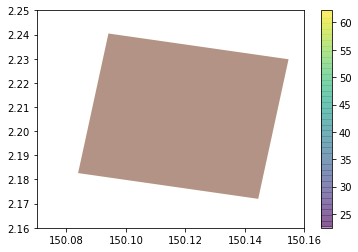

In [170]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

patches = []
#polygons = [d2i_polygon, j8pu3z010_polygon]#, j8pu40010_polygon]
polygons = [j8pu3z010_polygon, j8pu40010_polygon]
for polygon in polygons:
    polygon_obj = Polygon(polygon)
    patches.append(polygon_obj)
    
fig, ax = plt.subplots()
colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
plt.ylim(ymin = 2.16, ymax = 2.25)
plt.xlim(xmin = 150.07, xmax = 150.16)
plt.show()

Looking at the position bounds, we can see the MegaPrime image covers much more area than the HST image. We will download a cutout of the HST image, then use the astropy WCS package to find a rough cutout suitable for the MegaPrime image. Information about downloading data from CADC can be found here. Today we will use the requests library to download the first fits file. http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/doc/data/

In [188]:
cfht_mega_results = results[results['collection'] == 'CFHTMEGAPIPE']
hst_results = results[results['collection'] == 'HST']

cfht_mega_url = cadc.get_data_urls(cfht_mega_results)[0]
hst_url = cadc.get_data_urls(hst_results)[0]
# The include_auxillaries will include urls to preview files in addtion to the fits files
#[print(url) for url in urls];
# this one is good MegaPipe.301.184.R.MP9602
print(cfht_mega_url)
print(hst_url)

https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHTSG/D2.I.fits?RUNID=tduehvsqxkpsmdez
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/j8pu3z010_drc.fits?RUNID=m7b7yttjzpudva2y


The url's can be broken into a few parts. Take 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHTSG/MegaPipe.299.183.I.MP9702.fits?RUNID=f842u7t5dzws8mgy' as an example...
- 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/': This is the service url. The 'data/pub' ending accesses all public files. For files the requires authorization, there will be a redirect to 'data/auth' which require authorization
- CFHTSG: This is the archive name.
- MegaPipe.299.183.I.MP9702.fits: This is the file name.
- RUNID=f842u7t5dzws8mgy: These are additional query parameters. I don't exactly know what this means!


The urls give access to the actual data, so now we can fetch the file, perhaps do a cutout, open it with the astropy fits module, and display an image!

In [259]:
hst_fname

'j8pu3z010_drc.50_300_50_300.fits'

In [415]:
import re
import requests

def download_url_to_file(url, cutout=None):
    
    def get_filename(response):
        content_disposition = response.headers['Content-Disposition']
        return re.findall("filename=(.+)", content_disposition)[0]

    resp = requests.get(url, params={'cutout': cutout}) if cutout else requests.get(url)
    fname = get_filename(resp)
    
    file_name_and_path = 'data/{fname}'.format(fname=fname)
    # Note: wb will overwrite if something is already there
    with open(file_name_and_path, 'wb') as f:
        f.write(resp.content)
        
    return file_name_and_path

def get_image_data(file, ext=1):
    with fits.open(file) as hdulist:
        hdulist.info()
        w = wcs.WCS(hdulist[ext].header)
        image_data = hdulist[ext].data
    return image_data, w




In [446]:
hst_fname = download_url_to_file(hst_url)
hst_image_data, hst_w = get_image_data('{fname}'.format(fname=hst_fname), ext=1)


Filename: data/j8pu3z010_drc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     851   ()      
  1  SCI           1 ImageHDU        78   (4223, 4422)   float32   
  2  WHT           1 ImageHDU        46   (4223, 4422)   float32   
  3  CTX           1 ImageHDU        39   (4223, 4422)   int32   
  4  HDRTAB        1 BinTableHDU    631   8R x 311C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 23A, D, D, D, D, K, K, K, 8A, K, 23A, 9A, 20A, K, 4A, K, K, K, K, K, K, 23A, D, D, D, D, K, K, 3A, 3A, 4A, 4A, L, D, D, D, 3A, 1A, K, D, D, D, 13A, 3A, 4A, 4A, 12A, 12A, 23A, 8A, 23A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 23A, D, K, D, 6A, 9A, 8A, D, D, L, 4A, 18A, 3A, K, 7A, 5A, 3A, D, 13A, 8A, 4A, 3A, L, K, L, K, L, K, K, D, D, D, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, 23A, L, 1A, 3A, 1A, D, 3A, 6A, K, D, D, D, D, D, D, D, D, D, D, 23A, D, D, D, D, 3A, D,

In [434]:
cfht_fname = download_url_to_file(cfht_mega_url, cutout='[9000:10000,10500:11500]')
cfht_image_data, cfht_mega_w = get_image_data('{fname}'.format(fname=cfht_fname), ext=0)


Filename: data/D2.I.9000_10000_10500_11500.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     616   (1001, 1001)   float32   


In [419]:
px = [0, hst_image_data.shape[0]-1]
py = [0, hst_image_data.shape[1]-1]
lon, lat = hst_w.all_pix2world(px, py, 0)
print(lon)
print(lat)

[150.15226743 150.14582659]
[2.22806948 2.22356321]


In [435]:
px = [0, cfht_mega_data.shape[0]-1]
py = [0, cfht_mega_data.shape[1]-1]
lon, lat = cfht_mega_w.all_pix2world(px, py, 0)
print(lon)
print(lat)

[150.17671952 150.12503177]
[2.19666799 2.24831928]


In [453]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def print_image_stats(image_data, title):
    print(title)
    stats = {'min': np.nanmin(image_data), 'max': np.nanmax(image_data), 'mean': np.nanmean(image_data), 
            'std': np.nanstd(image_data)}
    print('Min: {min} \nMax: {max} \nMean: {mean}\nStdev: {std}'.format(**stats))
    
def plot_image(image_data, wcs):
    ax = plt.subplot(projection=wcs)
#     ax.set_xlim(-0.5, image_data.shape[1] - 0.5)
#     ax.set_ylim(-0.5, image_data.shape[0] - 0.5)
    ax.imshow(image_data, vmin=0, vmax=0.1, origin='lower')
    ax.contour(image_data, transform=ax.get_transform(wcs), levels=np.logspace(-5, 1, num=3,  base=2,), colors='red')
    ax.grid(color='white', ls='solid')
    plt.xlabel('Galactic Longitude')
    plt.ylabel('Galactic Latitude')
    
def plot_dual_wcs_images(image_data_a, wcs_a, image_data_b, wcs_b):
    ax = plt.subplot(projection=wcs_a)
    ax.set_xlim(-0.5, image_data_a.shape[1] - 0.5)
    ax.set_ylim(-0.5, image_data_a.shape[0] - 0.5)
    ax.imshow(image_data_a, vmin=0, vmax=1, origin='lower')
    ax.contour(image_data_b, transform=ax.get_transform(wcs_b), levels=np.logspace(-4, 1, num=3,  base=2,), colors='red')
    ax.grid(color='white', ls='solid')
    plt.xlabel('Galactic Longitude')
    plt.ylabel('Galactic Latitude')


HST Image Stats
Min: -0.03784549981355667 
Max: 0.3244381546974182 
Mean: 0.0034072110429406166
Stdev: 0.00963521096855402


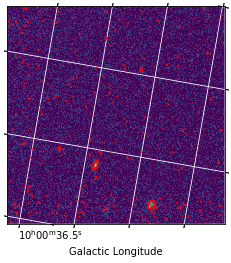

In [389]:
title = 'HST Image Stats'
print_image_stats(hst_image_data, title)
plot_image(hst_image_data, hst_w)

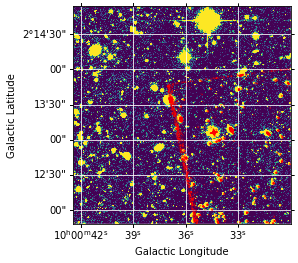

In [454]:
plot_dual_wcs_images(cfht_mega_data, cfht_mega_w, hst_image_data, hst_w)

That looks pretty weird... 
Now, lets try and use a cutout!